# Short PV techno-economic calculation for Casamance

Self-consumption assessment for a PV system in Cap Skirring, Sénégal

The consumption mainly covers the use of pumps from a two-boreholes well.

All codes and data, unless otherwise specified, are released under the MIT 2.0 and CC-by 4.0 licenses.

Sylvain Quoilin, University of Liege

January 10th, 2022


## Get PV generation data from renewable.ninja

In [1]:
import requests
import pandas as pd
import json
import prosumpy

token = '0978fcff598cc3de025ecfdc40cda1be3b055b47 '
api_base = 'https://www.renewables.ninja/api/'

s = requests.session()
# Send token header with each request
s.headers = {'Authorization': 'Token ' + token}

url = api_base + 'data/pv'

args = {
    'lat': 12.4,     # latitude for Cap Skirring
    'lon': -16.7,    # longitude for Cap Skirring
    'date_from': '2015-01-01',
    'date_to': '2015-12-31',
    'dataset': 'merra2',
    'capacity': 1.0,
    'system_loss': 0.1,
    'tracking': 0,
    'tilt': 13,
    'azim': 180,
    'format': 'json'
}

r = s.get(url, params=args)

# Parse JSON to get a pandas.DataFrame of data and dict of metadata
parsed_response = json.loads(r.text)

data = pd.read_json(json.dumps(parsed_response['data']), orient='index')
data.to_csv()
metadata = parsed_response['metadata']
pv = data['electricity']

In [99]:
# The same as above, but with a local file:
pv = pd.read_csv('PV_casamance - ninja data.csv',index_col=0,parse_dates=True)
pv = pv['electricity']

Average Capacity factor: 0.16562305936073088
PV generation: 1450.8580000000024 kWh/kWp
Max capacity factor: 0.79


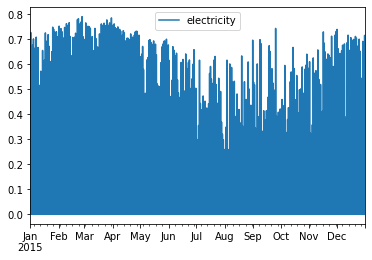

In [2]:
# check data:
%matplotlib inline
data.plot()
print('Average Capacity factor: ' + str(pv.mean()))
print('PV generation: ' + str(pv.mean()*8760) + ' kWh/kWp')
print('Max capacity factor: ' + str(pv.max()))
data.to_csv('PV_casamance - ninja data.csv')


# PV Data from PVgis

Average Capacity factor: 0.19176510502283134
PV generation: 1679.8623200000025 kWh/kWp
Max capacity factor: 0.8236500000000001


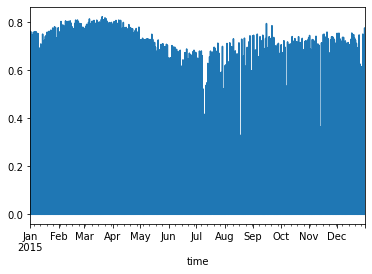

In [3]:
import pandas as pd

pvgis = pd.read_csv('PV_casamance - pvgis data.csv',index_col=0,parse_dates=True,skiprows=10)
pv_gis = pvgis[pvgis.index.year==2015]['P']/42000

# check data:
pv_gis.plot()
print('Average Capacity factor: ' + str(pv_gis.mean()))
print('PV generation: ' + str(pv_gis.mean()*8760) + ' kWh/kWp')
print('Max capacity factor: ' + str(pv_gis.max()))


## Conclusion on data selection
The data from PVGis leads to high capacity factors compared to monitoring data (about 12% too high). The data from renewables.ninja seems more realistic and will therefore be used

# Consumption profiles
Since no hourly data is available, synthetic consumption profiles are defined and will be upscaled to the right consumption.


In [4]:
profile = pd.read_csv('PV_casamance - yearly profiles.csv',index_col=0,parse_dates=True)

demand_night = profile['Lighting and others'] + profile['Plunger Pump'] + profile['Surpresseurs']
demand_day = profile['Lighting and others'] + profile['Plunger Pump day'] + profile['Surpresseurs']

# plotting the consumption profiles:

<AxesSubplot:>

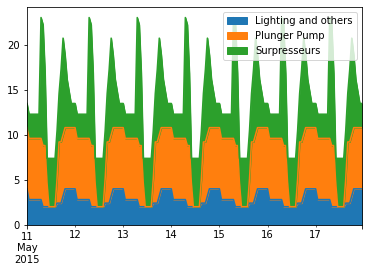

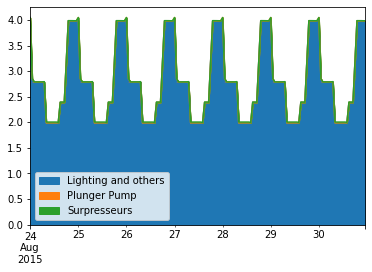

In [12]:
profile2 = profile[['Lighting and others','Plunger Pump','Surpresseurs']]
profile2[profile2.index.isocalendar().week==20].plot.area()
profile2[profile2.index.isocalendar().week==35].plot.area()

# Case 1: Without battery, pumping during the night

Total yearly consumption: 8.08e+04 kWh
Total PV production: 6.23e+04 kWh
Self Consumption: 2.44e+04 kWh
Total fed to the grid: 3.79e+04 kWh
Total bought from the grid: 5.64e+04 kWh
Self consumption rate (SCR): 39.2%
Self sufficiency rate (SSR): 30.2%
Amount of energy provided by the battery: 0.00365 kWh
Average Charging/Discharging depth: 1
Number of equivalent full cycles per year: 365 
Total battery losses: 0 kWh
Total inverter losses: 0 kWh
Residue (check): 1.46e-11 kWh


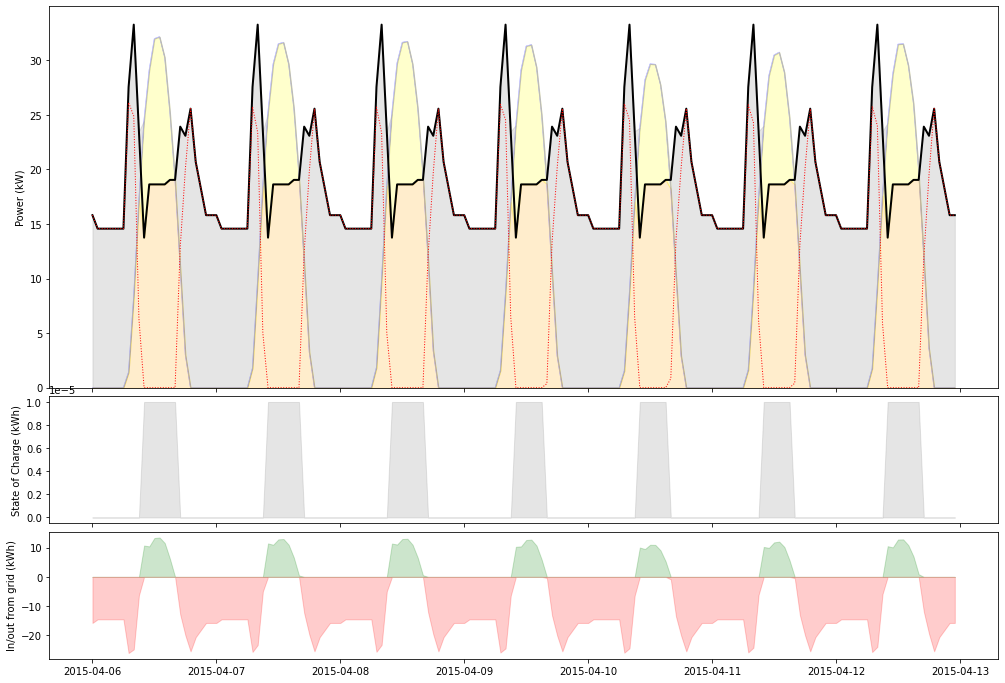

In [10]:
PV = pd.Series(pv.values*42.93,index=demand_day.index)
DEMAND = pd.Series(demand_night.values,index=demand_night.index)
param = {'BatteryCapacity': 1E-5,'BatteryEfficiency': 0.92,'InverterEfficiency': 1,'timestep': 1,'MaxPower': 100}
results = prosumpy.dispatch_max_sc(PV,DEMAND,param)
prosumpy.analysis.print_analysis(PV,DEMAND,param,results)
prosumpy.plot_dispatch(PV,DEMAND,results,week=15)

# Case 2: With battery, pumping during the night

Total yearly consumption: 8.08e+04 kWh
Total PV production: 6.23e+04 kWh
Self Consumption: 3.79e+04 kWh
Total fed to the grid: 2.44e+04 kWh
Total bought from the grid: 4.29e+04 kWh
Self consumption rate (SCR): 60.9%
Self sufficiency rate (SSR): 46.9%
Amount of energy provided by the battery: 1.35e+04 kWh
Average Charging/Discharging depth: 0.989
Number of equivalent full cycles per year: 361 
Total battery losses: 0 kWh
Total inverter losses: 0 kWh
Residue (check): 0 kWh


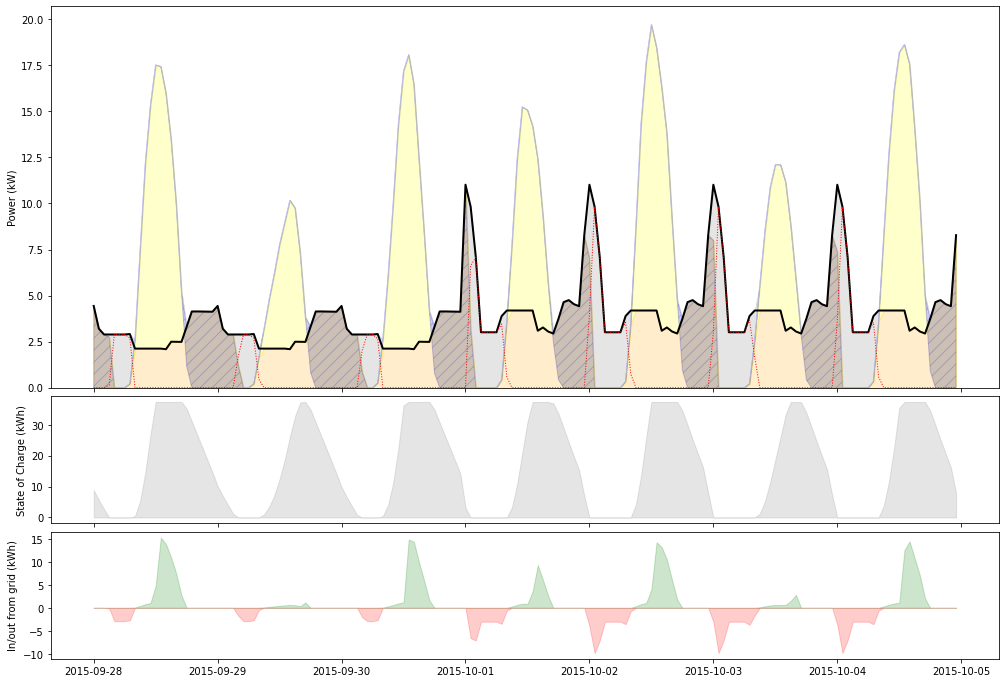

In [7]:
PV = pd.Series(pv.values*42.93,index=demand_day.index)
DEMAND = pd.Series(demand_night.values,index=demand_night.index)
param = {'BatteryCapacity': 41.58 * 0.9,'BatteryEfficiency': 0.92,'InverterEfficiency': 1,'timestep': 1,'MaxPower': 100}
results = prosumpy.dispatch_max_sc(PV,DEMAND,param)
prosumpy.analysis.print_analysis(PV,DEMAND,param,results)
prosumpy.plot_dispatch(PV,DEMAND,results,week=40)

# Case 3: With battery, pumping during the day

Total yearly consumption: 8.08e+04 kWh
Total PV production: 6.23e+04 kWh
Self Consumption: 4.75e+04 kWh
Total fed to the grid: 1.48e+04 kWh
Total bought from the grid: 3.33e+04 kWh
Self consumption rate (SCR): 76.3%
Self sufficiency rate (SSR): 58.8%
Amount of energy provided by the battery: 1.28e+04 kWh
Average Charging/Discharging depth: 0.935
Number of equivalent full cycles per year: 341 
Total battery losses: 0 kWh
Total inverter losses: 0 kWh
Residue (check): -2.91e-11 kWh


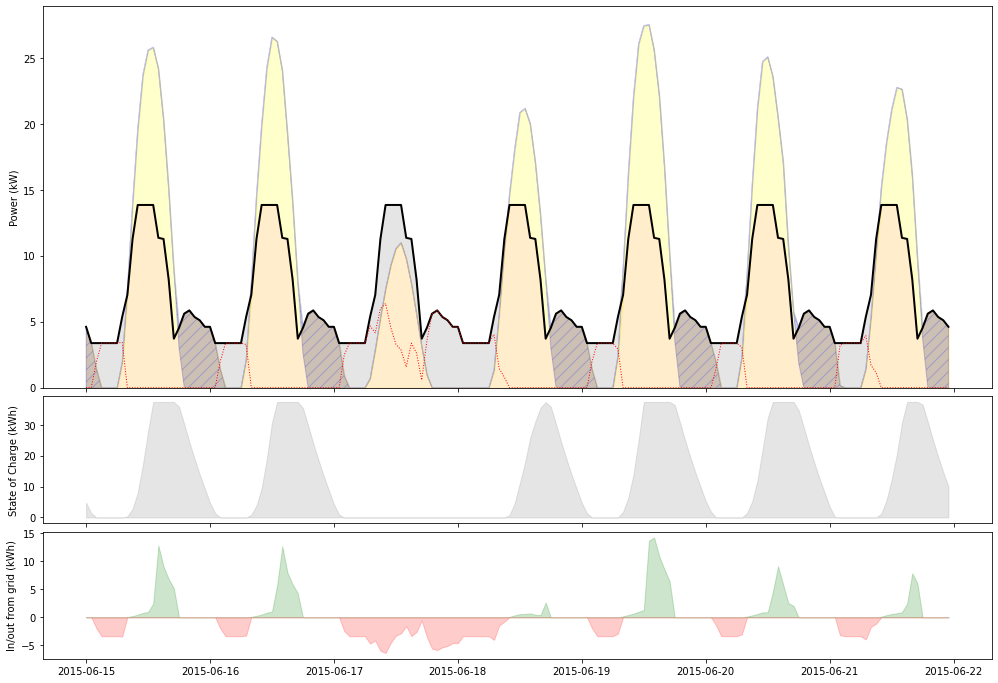

In [11]:
PV = pd.Series(pv.values*42.93,index=demand_day.index)
DEMAND = pd.Series(demand_day.values,index=demand_night.index)
param = {'BatteryCapacity': 41.58 * 0.9,'BatteryEfficiency': 0.92,'InverterEfficiency': 1,'timestep': 1,'MaxPower': 100}
results = prosumpy.dispatch_max_sc(PV,DEMAND,param)
prosumpy.analysis.print_analysis(PV,DEMAND,param,results)
prosumpy.plot_dispatch(PV,DEMAND,results,week=25)

# Conclusions

- PV generation from PVgis is too optimistic (about 15%), but this only marginally affects the self-consumption figures
- Self-consumption is highly dependent on the hourly consumption profiles, monitoring data would be needed to refine the assessment
- Without battery, consumption could be reduced by 2.44e+04 kWh
- With battery, consumption could be reduced by 3.79e+04 kWh
- With battery and day pumping, consumption could be recuded by 4.75e+04 kWh

## Available data cross-check and open questions:

Data:

From https://www.sunnyportal.com/Templates/PublicPageOverview.aspx?plant=6563de43-755f-4230-a781-45e2452da678&splang
- For Ziguinchor: 1450 kWh/kWp

From "Analysis and feasibility of 50 kWp self-consumption solar photovoltaic system for four Senegalese typical climatic zones using PVsyst software, 2020"
- Use model PVSYST - Climate data from helioclim-3
- 1.186 kWh/kWp for Ziguinchor 
- Losses seem very high
- Titl angle: 13°
- 15% reduction in PV yield from Dakar to Ziguinchor

From https://icew.de/wp-content/uploads/2019/10/LoSENS.pdf
- Grid tariff: 13 €ct/kWh

From: https://www.wearefactor.com/docs/Senegal.pdf
- 1,650 kWh/kWp for the Senegal. Lower value expected in Casamance 

from Performance analysis of the 23 MWp grid connected photovoltaic plant in Diass Senegal
- 4 kWh/kWhp/d => 1440 kWh/kWp    for a monitored system close to dakar

From: https://www.pv-magazine.com/2019/07/22/engie-secures-financing-for-60-mw-of-solar-in-senegal/
60MW PV plants secured by Engie: A PV plant in Tauba will sell power for €0.0380/kWh and a second facility in Kahone which will sell electricity for €0.0398. 



Battery cost:
6000€ per 15.4 kWh battery (dc-connected, 50V) => 400€/kWh

why not using DC everywhere? why SMA TRI?